## Implementación en Python del proceso de mejora de contraste:


**Explicación del código:**

* La función `enhance_contrast` toma una imagen EL como entrada y devuelve una imagen con el contraste mejorado.
* La función primero difumina la imagen con un filtro gaussiano para eliminar el ruido.
* Luego, se aplica un cierre morfológico para eliminar pequeñas imperfecciones y mejorar la uniformidad del fondo.
* La imagen original se divide por la imagen de fondo, lo que atenúa el ruido y resalta las regiones de alto contraste.
* Finalmente, se aplica la ecualización del histograma para aumentar el contraste general de la imagen.


In [1]:
# Importación de librerías

import cv2
import numpy as np

In [6]:
# Función para mejorar el contraste de una imagen EL
def enhance_contrast(image):
  """
  Mejora el contraste de una imagen EL.

  Parámetros:
    image: La imagen EL de entrada.

  Devuelve:
    La imagen con el contraste mejorado.
  """

  # Paso 1: Difuminar la imagen

  kernel_size = (5, 5)
  sigma = 1.0
  blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)

  # Paso 2: Cierre morfológico

  kernel = np.ones(( 5, 5), np.uint8)
  closed_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)

  # Paso 3: División

  bg_image = closed_image.copy()

  # Evitar la división por cero
  bg_image[bg_image == 0] = 1
  divided_image = image / bg_image

  # Paso 4: Ecualización del histograma

  enhanced_image = cv2.equalizeHist(divided_image.astype(np.uint8))

  return enhanced_image
  #return divided_image



In [4]:
def enhance_contrast(image, clip_limit=56.0, tile_grid_size=(4,4)):
    # clipLimit=2.0, tileGridSize=(8,8)
    # Aplicar desenfoque gaussiano
    kernel_size = 5
    sigma = 1.0
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

    # Realizar cierre morfológico
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

    # Evitar la división por cero
    closed[closed == 0] = 1

    # Dividir la imagen original por la imagen de fondo
    division = image / closed

    # Crear objeto CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Aplicar ecualización adaptativa del histograma
    enhanced_image = clahe.apply(division.astype('uint8'))

    return enhanced_image

In [7]:
# Ejemplo de uso

# Variable para almacenar el directorio de la imagen
path_EL = "D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PVDefectDetect/Test_ImageJ/"
image = cv2.imread(path_EL + "example_10.png", cv2.IMREAD_GRAYSCALE)
#image = cv2.imread(path_EL + "MAX_070A_8v.tif", cv2.IMREAD_GRAYSCALE)
enhanced_image = enhance_contrast(image)

cv2.imshow("Imagen original", image)
cv2.imshow("Imagen con contraste mejorado", enhanced_image)
cv2.waitKey(0)

-1

## Procesamiento de una secuencia de imágenes

In [1]:
import cv2
import numpy as np
import os
from os import listdir, path
from matplotlib import pyplot as plt




In [2]:
# Función para la lectura de imágenes

def read_images(directory, allow_color_images=False):
    """
    Lee todas las imágenes en un directorio

    Parámetros

    directory: str
        Directorio con las imágenes
    allow_color_images: bool
        Permite el uso de imágenes a color

    Retorna

    images: list
        Lista con las imágenes
    """
    # Leer todas las imágenes en el directorio
    images = []
    for f in listdir(directory):
        if f.endswith('.jpg') or f.endswith('.png'):
            image = cv2.imread(path.join(directory, f), cv2.IMREAD_GRAYSCALE)
            if allow_color_images:
                image = cv2.imread(path.join(directory, f), cv2.IMREAD_COLOR)
            images.append(image)
    return images

In [4]:
# Ruta de las imágenes
image_path = "E:/Panel_30W/P13/V24.2_I2.50_t30/JPEG_8"
background_path = "E:/Panel_30W/P13/V24.2_I2.50_t30/fondo_8/JPEG_fondo_8"
output_noBG_path = 'E:/Panel_30W/Salida13/P8/dataset_noBG'

datasetEL = read_images(image_path)
datasetBG = read_images(background_path)


# Imprime el número de imágenes en cada dataset
# para probar que las imágenes se agregaron
print("Imágenes en el dataset EL: ", len(datasetEL))
print("Imágenes en el dataset BG: ", len(datasetBG))

Imágenes en el dataset EL:  51
Imágenes en el dataset BG:  51


In [5]:
# Funciones para mejorar la calidad de las imágenes

def enhance_contrast(image):
    """
    Mejora el contraste de una imagen EL.

    Parámetros:
        image: La imagen EL de entrada.
        clip_limit: Límite de contraste para la ecualización adaptativa del histograma.
        tile_grid_size: Tamaño de la cuadrícula para la ecualización adaptativa del histograma.

    Devuelve:
        La imagen con el contraste mejorado.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_image = clahe.apply(image)
    return enhanced_image

# Eliminar pixeles calientes: radio de pixel = 2.0; Threshold = 50

def remove_hot_pixels(image):
    """
    Elimina los pixeles calientes de una imagen EL.

    Parámetros:
        image: La imagen EL de entrada.
        radius: Radio del pixel caliente.
        threshold: Umbral para la eliminación de pixeles calientes.

    Devuelve:
        La imagen sin pixeles calientes.
    """
    radius=2.0
    threshold=180
    ret, mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    image = cv2.inpaint(image, mask, 2, cv2.INPAINT_TELEA)

    return image

# Función para resaltar los defectos en una imagen EL
def highlight_defects(image):
  """
  Mejora el contraste de una imagen EL.
  Parámetros:
    image: La imagen EL de entrada.
  Devuelve:
    higlight_image: La imagen con el contraste mejorado.
  """
  # Paso 1: Difuminar la imagen

  kernel_size = (3, 3)
  sigma = 1.0
  blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)

  # Paso 2: Cierre morfológico

  #kernel = np.ones(( 5, 5), np.uint8)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  #closed_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)
  closed_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)

  # Paso 3: División

  bg_image = closed_image.copy()

  # Evitar la división por cero
  bg_image[bg_image == 0] = 1
  divided_image = image / bg_image

  # Paso 4: Ecualización del histograma

  clip_limit=50.0
  tile_grid_size=(4,4)

  # Crear objeto CLAHE
  clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

  #higlight_image = cv2.equalizeHist(divided_image.astype(np.uint8))
  # Aplicar ecualización adaptativa del histograma
  higlight_image = clahe.apply(divided_image.astype('uint8'))

  return higlight_image


def SubtractBG(datasetEL, datasetBG, output_noBG_path):
    # Comprueba que los dos conjuntos de datos tienen la misma longitud
    if len(datasetEL) != len(datasetBG):
        raise ValueError("Los conjuntos de datos EL y BG deben tener la misma longitud")

    dataset_noBG = [0] * len(datasetEL)  # Inicializa la lista con ceros
    for i in range(len(datasetEL)):
        # Comprueba que las dos imágenes tienen la misma forma
        if datasetEL[i].shape != datasetBG[i].shape:
            raise ValueError(f"Las imágenes en el índice {i} no tienen la misma forma")

        dataset_noBG[i] = datasetEL[i].astype('float32') - datasetBG[i].astype('float32')

        # Almacena el dataset en el output_noBG_path con nombres numerados
        filename = f"EL_noBG_{i}.jpg"
        output_filepath = os.path.join(output_noBG_path, filename)

        # Convierte la matriz de imagen a tipo uint8 antes de guardarla
        dataset_noBG_uint8 = cv2.normalize(dataset_noBG[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        cv2.imwrite(output_filepath, dataset_noBG_uint8)
        print(f"Imagen {i} guardada como {filename}")
        
    return dataset_noBG_uint8



In [30]:
# Nuevo dataset sin fondo
dataset_noBG = SubtractBG(datasetEL, datasetBG, output_noBG_path)


#imagenes = dataset_noBG
print("imagenes en el dataset: ", len(dataset_noBG))

Imagen 0 guardada como EL_noBG_0.jpg
Imagen 1 guardada como EL_noBG_1.jpg
Imagen 2 guardada como EL_noBG_2.jpg
Imagen 3 guardada como EL_noBG_3.jpg
Imagen 4 guardada como EL_noBG_4.jpg
Imagen 5 guardada como EL_noBG_5.jpg
Imagen 6 guardada como EL_noBG_6.jpg
Imagen 7 guardada como EL_noBG_7.jpg
Imagen 8 guardada como EL_noBG_8.jpg
Imagen 9 guardada como EL_noBG_9.jpg
Imagen 10 guardada como EL_noBG_10.jpg
Imagen 11 guardada como EL_noBG_11.jpg
Imagen 12 guardada como EL_noBG_12.jpg
Imagen 13 guardada como EL_noBG_13.jpg
Imagen 14 guardada como EL_noBG_14.jpg
Imagen 15 guardada como EL_noBG_15.jpg
Imagen 16 guardada como EL_noBG_16.jpg
Imagen 17 guardada como EL_noBG_17.jpg
Imagen 18 guardada como EL_noBG_18.jpg
Imagen 19 guardada como EL_noBG_19.jpg
Imagen 20 guardada como EL_noBG_20.jpg
Imagen 21 guardada como EL_noBG_21.jpg
Imagen 22 guardada como EL_noBG_22.jpg
Imagen 23 guardada como EL_noBG_23.jpg
Imagen 24 guardada como EL_noBG_24.jpg
Imagen 25 guardada como EL_noBG_25.jpg
Imagen

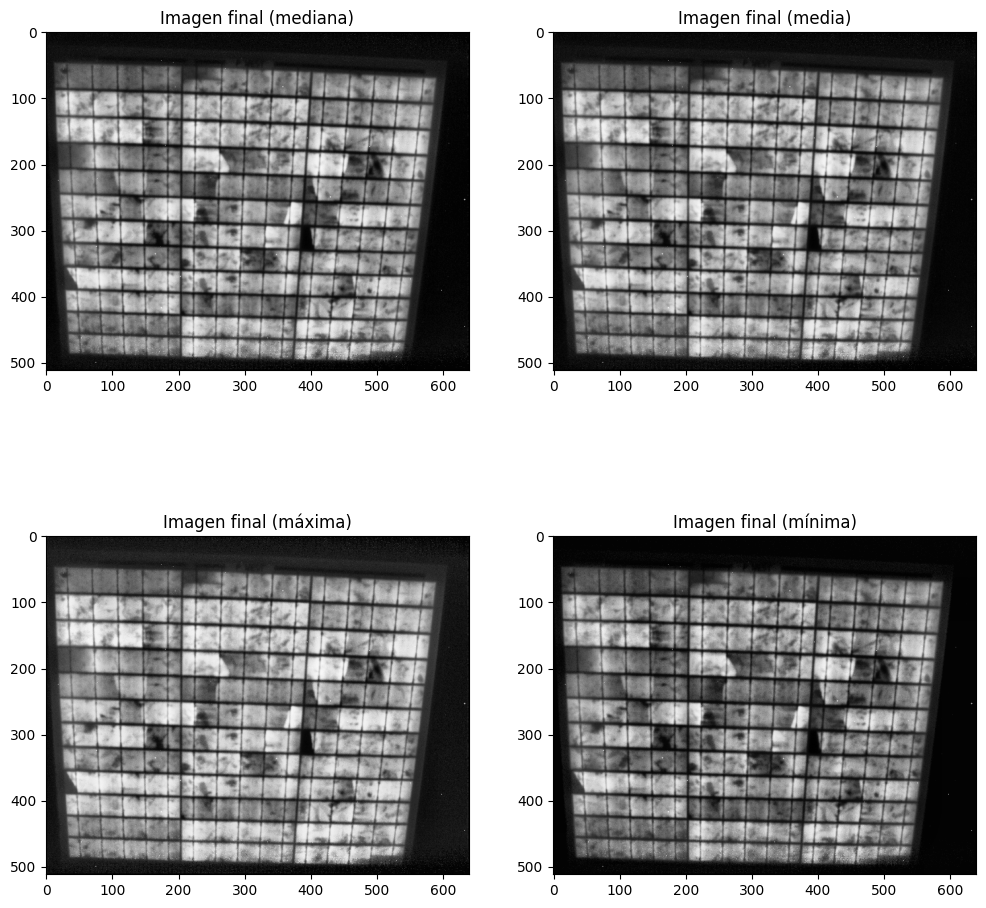

In [6]:
# Cargar las imágenes del dataset
#dataset_noBG = read_images(output_noBG_path)
#imagenes = [dataset_noBG[i] for i in range(0, len(dataset_noBG))]
imagenes = [datasetEL[i] for i in range(0, len(datasetEL))]
#imagenes = [cv2.imread(f'imagen{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1, 52)]

# Eliminar el fondo de las imágenes EL
#imagenes = SubtractBG(datasetEL, datasetBG)

# Procesar cada imagen
for i in range(len(imagenes)):
    # Eliminar pixeles calientes
    """blur = cv2.GaussianBlur(imagenes[i], (7, 7), 0)
    _, img_th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    median = cv2.medianBlur(img_th, 5)
    imagenes[i] = cv2.subtract(imagenes[i], median)

    # Eliminar pixeles muertos
    _, img_th = cv2.threshold(imagenes[i], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    median = cv2.medianBlur(img_th, 151)
    imagenes[i] = cv2.add(imagenes[i], median)"""

    

    # Mejorar contraste
    imagenes[i] = enhance_contrast(imagenes[i])

    # Eliminar ruido
    #imagenes[i] = cv2.fastNlMeansDenoising(imagenes[i], None, 1, 7, 21)

    # Eliminar pixeles calientes: radio de pixel = 2.0; Threshold = 50
    #imagenes[i] = remove_hot_pixels(imagenes[i])

    #ret, mask = cv2.threshold(imagenes[i], 180, 255, cv2.THRESH_BINARY)
    #imagenes[i] = cv2.inpaint(imagenes[i], mask, 2, cv2.INPAINT_TELEA)
    #blur = cv2.GaussianBlur(imagenes[i], (5, 5), 0)
    #_, img_th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #median = cv2.medianBlur(img_th, 5)
    #imagenes[i] = cv2.subtract(imagenes[i], median)

# Combinar las imágenes
imagen_final = np.median(np.array(imagenes), axis=0).astype(np.uint8)



# Establecer directorio de salida
#output_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PVDefectDetect/ImagePreprocessing/Salidas/Manejo_secuencia'
#output_path = 'E:/Panel_30W/Salida1'
#output_path = 'E:/Panel_30W/Salida4'
#output_path = 'E:/Panel_30W/Salida6'
#output_path = 'E:/Panel_30W/Salida12/V23-1_I1-5'
output_path = 'E:/Panel_30W/Salida13/P8bg'

# Guardar la imagen final usando la mediana de las imágenes del dataset
cv2.imwrite(path.join(output_path, 'imagen_final_mediana.png'), imagen_final)

# Guardar la imagen final usando la media de las imágenes del dataset
cv2.imwrite(path.join(output_path,'imagen_final_media.png'), np.mean(np.array(imagenes), axis=0).astype(np.uint8))

# Guardar la imagen final usando la máxima de las imágenes del dataset
cv2.imwrite(path.join(output_path,'imagen_final_maxima.png'), np.max(np.array(imagenes), axis=0).astype(np.uint8))

# Guardar la imagen final usando la mínima de las imágenes del dataset
cv2.imwrite(path.join(output_path,'imagen_final_minima.png'), np.min(np.array(imagenes), axis=0).astype(np.uint8))

# Mostrar las imagenes finales con subplots
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Imagen final (mediana)')
plt.imshow(imagen_final, cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Imagen final (media)')
plt.imshow(np.mean(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Imagen final (máxima)')
plt.imshow(np.max(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')
plt.subplot(2, 2, 4)
plt.title('Imagen final (mínima)')
plt.imshow(np.min(np.array(imagenes), axis=0).astype(np.uint8), cmap='gray')



#cv2.imshow("Imagen final", imagen_final)
#cv2.waitKey(0)

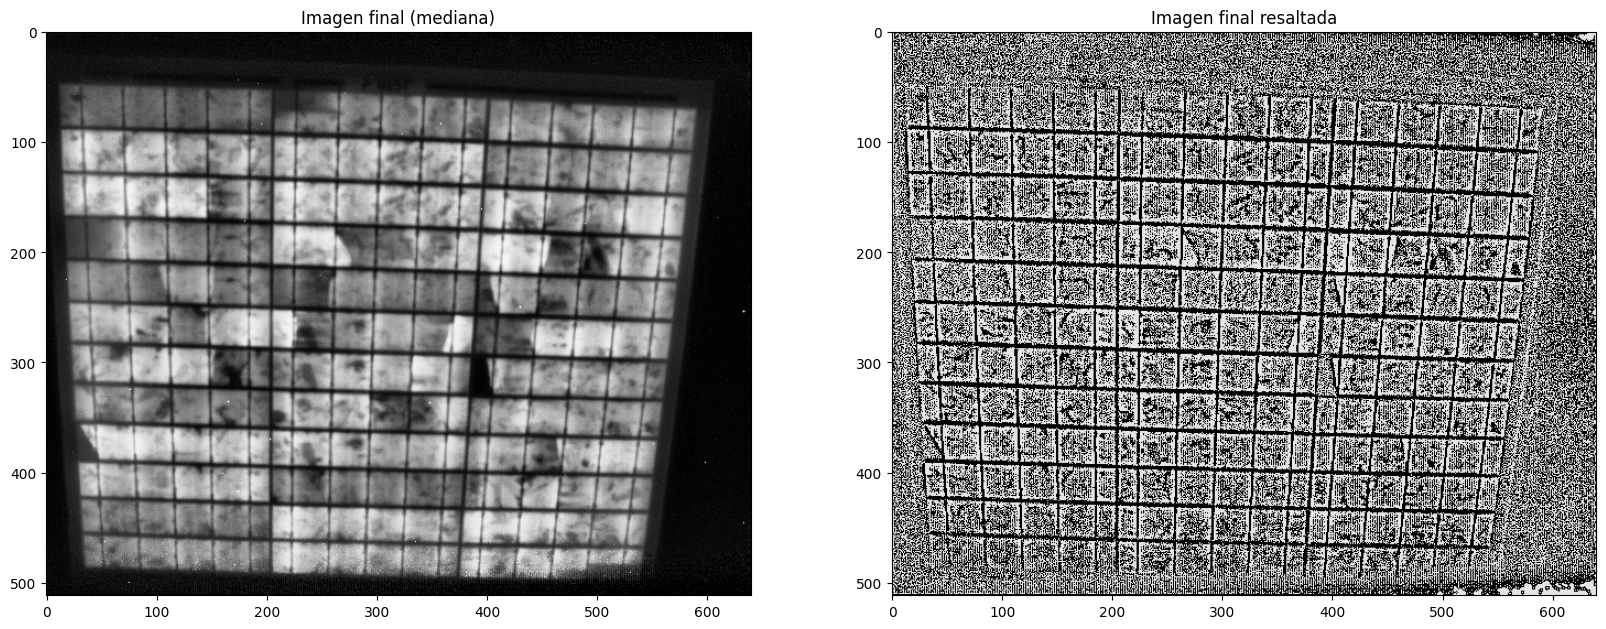

In [7]:
# Ejemplo de uso del resaltado de defectos

imagen_final_resaltada = highlight_defects(imagen_final)

# Guardar la imagen resaltada
cv2.imwrite(path.join(output_path,'imagen_final_resaltada.png'), imagen_final_resaltada)

# Mostrar la imagen resaltada junto con la imagen final
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Imagen final (mediana)')
plt.imshow(imagen_final, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Imagen final resaltada')
plt.imshow(imagen_final_resaltada, cmap='gray')
plt.show()

Relación de contraste máximo:

Esta métrica calcula la diferencia entre los valores de intensidad máximos y mínimos de la imagen.
Un valor más alto indica un mayor contraste.
Se puede calcular utilizando la siguiente fórmula:

In [ ]:
CR_max = (I_max - I_min) / I_min

Relación de contraste promedio:

Esta métrica calcula la diferencia promedio entre los valores de intensidad de píxeles vecinos.
Un valor más alto indica un mayor contraste.
Se puede calcular utilizando la siguiente fórmula:

In [ ]:
CR_avg = mean(abs(I(i, j) - I(i+1, j)) + abs(I(i, j) - I(i, j+1)))